# 1.使用神经网络对手写数字做分类

## 1.Mnist数据集
MNIST数据集改编自美国国家标准与技术研究所收集的NIST数据集。该数据集收集了来自250个不同人手写的数字图片，其中一半是人口普查局的工作人员，另一半是高中生。该数据集包括50000张训练集图片和10000张测试集图片，训练集和测试集都提供了正确答案。每张图片都是28×28=784大小的灰度图片，也就是一个28×28的矩阵，里面每个值是一个像素点，值在[0,1]之间，其中0表示白色，1表示黑色。

### 1.读取Mnist数据集
pkl是python内置的一种格式，可以将python的各种数据结构序列化存储到磁盘中，需要时又可以读取并反序列化到内存中。mnist.pkl.gz做了两次操作，先pkl序列化，再gz压缩存储，所以要读取该文件，需要先解压再反序列化。

In [4]:
import pickle
import gzip
from pathlib import Path

DATA_PATH = Path("../data/1")
PATH = DATA_PATH / "mnist"
FILENAME = "mnist.pkl.gz"

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [5]:
# x_train训练样本，是一个50000×784的矩阵，表示有50000个训练样本，每个训练样本是一个784的一维数组，784就是把一张28×28的图片展开成的一维数组
print(f"x_train:{x_train}")
print(f"x_train.shape:{x_train.shape}") # shape获取 矩阵的维度属性
# x_train训练样本对应的识别答案
print(f"y_train:{y_train}")
print(f"y_train.shape:{y_train.shape}")
print("\n")
print(f"x_valid:{x_valid}")
print(f"x_valid.shape:{x_valid.shape}")
print(f"y_valid:{y_train}") 
print(f"y_valid.shape:{y_valid.shape}")



x_train:[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
x_train.shape:(50000, 784)
y_train:[5 0 4 ... 8 4 8]
y_train.shape:(50000,)


x_valid:[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
x_valid.shape:(10000, 784)
y_valid:[5 0 4 ... 8 4 8]
y_valid.shape:(10000,)


### 2.使用matplotlib还原28*28矩阵对应的灰度图片

y_train[:6]:[5 0 4 1 9 2]


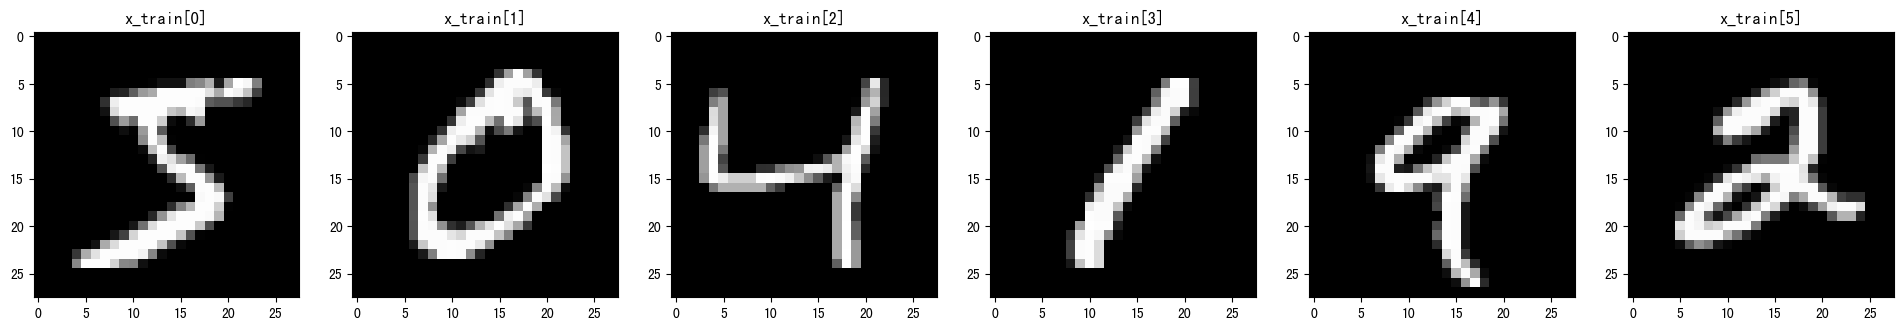

In [6]:
import matplotlib.pyplot as plt

# Plot the data
fig, ax = plt.subplots(1, 6, figsize=(24, 4))

for i in range(6):
    ax[i].imshow(x_train[i].reshape((28, 28)), cmap='gray')
    ax[i].set_title(f'x_train[{i}]')

print(f'y_train[:6]:{y_train[:6]}')

## 2.将数据需转换成tensor以便后续建模训练
Tensor是PyTorch中的基本数据类型，它是一个多维数组，可以用来表示向量、矩阵、甚至是更高维的数据。Tensor类似于Numpy中的数组，但是它可以在GPU上进行计算，从而加速计算过程。

在PyTorch中，我们可以使用Tensor来构建神经网络。通过多层Tensor的组合和非线性变换，我们可以实现复杂的非线性映射关系，从而对数据进行分类、识别、聚类等操作。

与Numpy中的数组类似，Tensor可以使用各种各样的操作进行计算，例如加法、乘法、矩阵乘法等。此外，PyTorch还提供了许多高级的操作，例如卷积、池化等等，可以方便地构建深度学习模型。


In [7]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

print(f"x_train转换tensor后的结构: {x_train}")
print(x_train.shape)
print(f"y_train转换tensor后的结构: {y_train}")
print(y_train.shape)


x_train转换tensor后的结构: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([50000, 784])
y_train转换tensor后的结构: tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000])


## 3.创建模型
1. FC = Wx+B：FC代表全连接层，表示输入向量x通过权重矩阵W（weight）进行线性变换，并加上偏差向量B(bias)，最终得到全连接层的输出。
2. nn.Module：用于定义神经网络的层、激活函数、损失函数等组件，可以方便地构建自定义神经网络。每个nn.Module实例都有一个`forward`方法，用于定义数据在神经网络中的正向传播过程。通过继承nn.Module类并实现forward方法，我们可以构建自己的神经网络。
3. nn.Linear：用于定义全连接层。它有两个参数`in_features`和`out_features`，分别表示输入特征的维度和输出特征的维度。通过实例化Linear，我们可以方便地构建全连接层，并将其作为神经网络的一部分来训练。
4. dropout：在训练过程中随机丢弃一部分神经元的输出来减少过拟合，一般每个全连接层都要加一个dropout。
5. F.relu：激活函数，负责将输入的神经元转换为输出。


In [8]:
from torch import nn
import torch.nn.functional as F

class Mnist_NN(nn.Module): # 继承nn.Module
    def __init__(self):
        super().__init__()

        self.hidden1 = nn.Linear(784, 128) # 全连接层1  输入784个像素点 输出128个特征
        self.hidden2 = nn.Linear(128, 256) # 全连接层2 输入128 输出256
        self.dropout = nn.Dropout(0.5) # 随机杀死一半，防止过拟合
        self.out = nn.Linear(256, 10) # 输出层  输入256 输出10个类别分别的概率

    # 前向传播
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

# 打印参数  
for name, parameter in Mnist_NN().named_parameters():
    print(f"参数名字:{name}, 参数矩阵的大小{parameter.size()}")

参数名字:hidden1.weight, 参数矩阵的大小torch.Size([128, 784])
参数名字:hidden1.bias, 参数矩阵的大小torch.Size([128])
参数名字:hidden2.weight, 参数矩阵的大小torch.Size([256, 128])
参数名字:hidden2.bias, 参数矩阵的大小torch.Size([256])
参数名字:out.weight, 参数矩阵的大小torch.Size([10, 256])
参数名字:out.bias, 参数矩阵的大小torch.Size([10])


## 4.打包数据：TensorDataset和DataLoader
1. TensorDataset：是一个用于包装张量的类，可以将多个张量打包成一个数据集。例如，我们可以将训练数据和对应的标签打包成一个TensorDataset对象，便于后续的数据处理和模型训练。
2. DataLoader：是一个用于加载数据的类，可以从TensorDataset对象中加载数据，并将其转换为可用于训练的批量数据。DataLoader类的实例可以指定批量大小、数据的采样方式、数据的并行加载方式等参数，可以方便地处理大规模数据集，并加速模型训练的过程。

在PyTorch中，通常使用TensorDataset和DataLoader配合使用，以便在训练过程中高效地加载和处理数据。具体来说，我们可以先将数据和标签打包成一个TensorDataset对象，然后使用DataLoader类来加载数据，并在训练过程中逐批地处理数据。这样可以方便地处理大规模数据集，并加速模型训练的过程。

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

bs = 64 # 每次迭代训练的样本数

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )


for xb, yb in train_dl:
    print(xb.shape) # 把数据打包成64大小的包
    print(yb.shape)
    break

torch.Size([64, 784])
torch.Size([64])


## 5. 训练

### 1. zip用法

In [10]:
a = [1, 2, 3]
b = [4, 5, 6]

zipped = zip(a, b)
print(zipped)
print(list(zipped)) 

a2, b2 = zip(*zip(a, b))
print(a2)
print(b2)

[(1, 4), (2, 5), (3, 6)]
(1, 2, 3)
(4, 5, 6)


### 2.训练模型

opt优化器:
- optim.Adam：是一种常用的随机梯度下降算法，具有自适应学习率和动量的特点，可以在处理大规模数据集和高维参数空间时保持良好的性能。
- optim.SGD：用于实现随机梯度下降优化算法。在SGD算法中，每次迭代时，我们随机选择一个样本或一批样本，并使用其梯度来更新模型的参数。通过使用随机梯度下降算法，我们可以逐渐优化模型的参数，并使其逼近最优解。
F.cross_entropy：交叉熵损失函数通常用于衡量模型的预测结果与真实标签之间的差距，一般用于多分类问题。我们需要将模型的输出结果与真实标签传递给该函数，然后该函数会自动计算交叉熵损失函数，并返回计算结果。

In [11]:
import numpy as np
from torch import optim

def get_model():
    model = Mnist_NN()
    # 返回模型和优化器，
    return model, optim.Adam(model.parameters(), lr=0.001)

def loss_batch(model, loss_func, xb, yb, opt=None):
    # 计算损失
    loss = loss_func(model(xb), yb) # model(xb) 预测值 yb 真实值

    if opt is not None: # 更新模型参数
        loss.backward() # 更新梯度
        opt.step() # 执行更新
        opt.zero_grad() # 单次更新完梯度置0 每次迭代独立去操作

    return loss.item(), len(xb)

# 训练
def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    """
        steps 迭代次数  
        model 模型 
        loss_func 损失函数 
        opt 优化器
        train_dl 训练打包器
        valid_dl 验证打包器
    """
    for step in range(steps):
        model.train() # 训练, 更新每一层的w、b
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval() # 验证
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        # 平均损失
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:'+str(step), '验证集损失：'+str(val_loss))


train_dl, valid_dl = get_data(train_ds, valid_ds, bs) # 数据
model, opt = get_model() # 模型
loss_func = F.cross_entropy # 损失函数 = 交叉熵
fit(20, model, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失：0.1790917843401432
当前step:1 验证集损失：0.1413043381676078
当前step:2 验证集损失：0.1260951141640544
当前step:3 验证集损失：0.10979448019750417
当前step:4 验证集损失：0.10589002510942519
当前step:5 验证集损失：0.0973514960790053
当前step:6 验证集损失：0.0931251249326393
当前step:7 验证集损失：0.09192329346649349
当前step:8 验证集损失：0.09291253246963024
当前step:9 验证集损失：0.0881119163621217
当前step:10 验证集损失：0.0942236721213907
当前step:11 验证集损失：0.08481052950480952
当前step:12 验证集损失：0.09074598312401212
当前step:13 验证集损失：0.09103907274901867
当前step:14 验证集损失：0.08305676858194638
当前step:15 验证集损失：0.0864960797618609
当前step:16 验证集损失：0.08637794858841226
当前step:17 验证集损失：0.08212501162248663
当前step:18 验证集损失：0.0879613714447245
当前step:19 验证集损失：0.08616981758172623


## 6. 验证
torch.max：用于计算张量沿指定维度的最大值，它接受两个参数，第一个参数是要计算最大值的张量，第二个参数是指定的维度。返回两个张量，第一个张量是最大值的值，第二个张量是最大值的索引。

### 1. 测试验证集部分数据的准确性

预测值：tensor([3, 8, 6, 9, 6, 9, 5, 3, 8, 4, 5, 2])


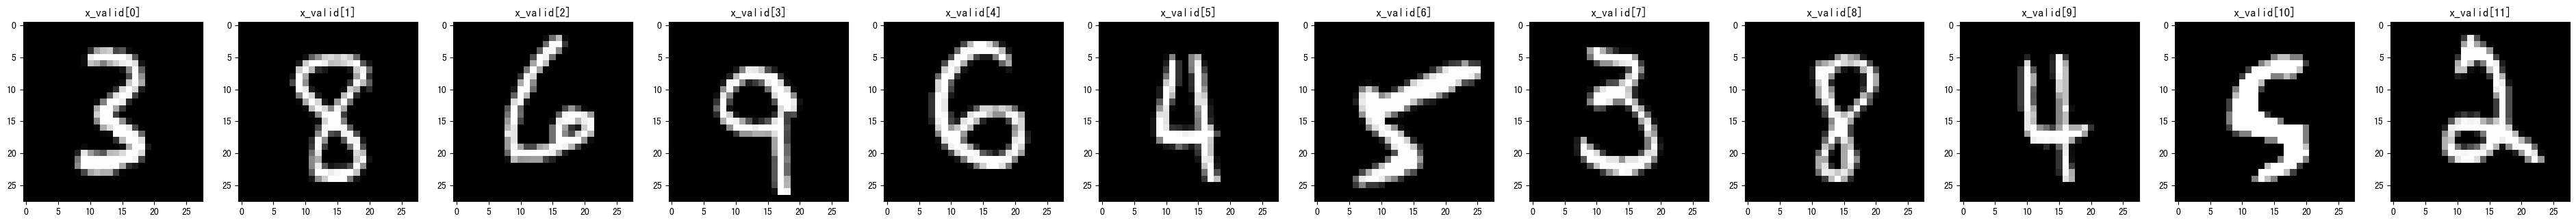

In [12]:
# 绘制出验证集前12个28*28矩阵对应的灰度图片
fig, ax = plt.subplots(1, 12, figsize=(48, 4))
for i in range(12):
    ax[i].imshow(x_valid[i].reshape((28, 28)), cmap='gray')
    ax[i].set_title(f'x_valid[{i}]')


# 打印部分模型预测数据
for xb, _ in valid_dl:
    outputs = model(xb)
    _, predicted = torch.max(outputs.data, 1) # 最大值和索引
    print(f"预测值：{predicted[:12]}" )
    break

### 2.计算准确率

In [13]:
correct = 0
total = 0
for xb, yb in valid_dl:
    outputs = model(xb)
    _, predicted = torch.max(outputs.data, 1) # 最大值和索引
    total += yb.size(0)
    correct += (predicted == yb).sum().item()
print("测试集准确率：%d %%" % (100*correct/total))

测试集准确率：97 %
